In [1]:
from utils import *
%matplotlib inline
%load_ext autoreload
%autoreload 2
vol_file = '../Analysis/depreciated/analysis_sections_gain.csv'
dat_xls_file = pd.read_csv(vol_file, index_col=0)
dat_xls_file['folder'] = dat_xls_file['folder'].apply(lambda x: f'{x:0>8}')
dat_xls_file = dat_xls_file.reset_index()
t_pre = 100 # time window pre-swim
t_post = 350 # time window post-swim
t_label = np.arange(-t_pre, t_post)/300
t_sig = 240

In [7]:
nfish = 1
row = dat_xls_file.iloc[nfish]
folder = row['folder']
fish = row['fish']
_ = np.load(f'../Analysis/swim_power/{folder}_{fish}_swim_dat.npz')
swim_starts = _['swim_starts']
swim_ends = _['swim_ends']
r_swim = _['r_swim']
l_swim = _['l_swim']
visu = _['visu']
task_period = _['task_period']
swim_task_index = _['swim_task_index']

trial_valid = np.ones(len(swim_starts)).astype('bool')
for n, n_swim in enumerate(swim_starts[:-1]):        
    # examine the swim with short inter-swim-interval
    if swim_starts[n+1] - n_swim < t_sig:    
        trial_valid[n] = False

p_swim = l_swim+r_swim

ncell_ = 6
_ = np.load(f'../Analysis/swim_voltr/{folder}_{fish}_swim_voltr_dat.npz')
# trial_valid = _['trial_valid']
sub_swim = _['sub_swim'][ncell_]
spk_swim = _['spk_swim'][ncell_]*300
spk_list = _['raw_spk_swim'][ncell_]

sub_list = sub_swim-sub_swim[:, 70:75].mean(axis=-1, keepdims=True)

trial_valid_fit = trial_valid & ((visu[:,:t_pre-10]<=0).sum(axis=-1)==0)

In [20]:
Y_dat = []
X_dat = []

for n_, dff_ in enumerate(sub_list):
    if not trial_valid_fit[n_]:
        continue
    spk_ = spk_list[n_]
    swim_ = p_swim[n_]
    visu_ = -visu[n_]
    visu_[visu_<0]=0
    for n_time in range(t_pre, t_pre+240):
        spk_history=spk_[n_time-1:n_time]
        swim_history=swim_[n_time-30:n_time+30]
        visu_pad = 60
        if n_time>120:
            visu_history=visu_[n_time-visu_pad:n_time]
        else:
            visu_history=np.zeros(visu_pad)
        Y_dat.append(dff_[n_time]-dff_[n_time-30])
        X_dat.append(np.r_[-spk_history, -np.sqrt(swim_history)/100, -np.sqrt(visu_history)/100])

In [21]:
Y_dat = np.array(Y_dat)
X_dat = np.array(X_dat)

In [22]:
reg = LinearRegression(fit_intercept=False).fit(X_dat, Y_dat)

In [23]:
w = reg.coef_

In [24]:
w, rnorm = nnls(X_dat, Y_dat)

In [25]:
Y_hat = X_dat.dot(w)

In [26]:
1 - ((Y_dat-Y_hat)**2).sum()/((Y_dat-Y_dat.mean())**2).sum()

0.13654203577307422

In [27]:
1 - ((Y_dat-X_dat[:,:2].dot(w[:2]))**2).sum()/((Y_dat-Y_dat.mean())**2).sum()

-0.0010646979445037008

In [28]:
1 - ((Y_dat-X_dat[:,2:62].dot(w[2:62]))**2).sum()/((Y_dat-Y_dat.mean())**2).sum()

0.13466500501414214

In [29]:
1 - ((Y_dat-X_dat[:,62:].dot(w[62:]))**2).sum()/((Y_dat-Y_dat.mean())**2).sum()

0.015585679883488357

Text(0.5, 0, 'time (ms)')

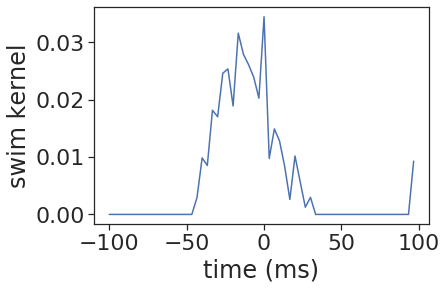

In [30]:
plt.plot(np.arange(-30,30)/300*1000, w[1:61])
plt.ylabel('swim kernel')
plt.xlabel('time (ms)')

Text(0.5, 0, 'time (ms)')

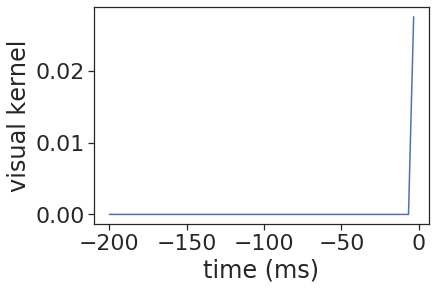

In [31]:
plt.plot(np.arange(-visu_pad,0)/300*1000, w[61:])
plt.ylabel('visual kernel')
plt.xlabel('time (ms)')